# EPFL BIO 322 Project  
### Gene Prediction based on Mouse brain single cell gene expression profiles

### Authors:

- Simon Lee (simon.lee@epfl.ch) 
- Léa Goffinet (lea.goffinet@epfl.ch)

### Project Description

In an experiment on epigenetics and memory, Giulia Santoni (from the lab of Johannes Gr¨aff at
EPFL) measured the gene expression levels in multiple cells of a mouse brain under three different
conditions that we call KAT5, CBP and eGFP. In this challenge, the goal is to predict – as accurately
as possible – for each cell the experimental condition (KAT5, CBP or eGFP) under which it was
measured, given only the gene expression levels.

In [2]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

from tqdm import tqdm
import requests
import os
import sys
from pathlib import Path
import multiprocessing as mp
from multiprocessing import Process
import concurrent
from multiprocessing import Pool
import xgboost as xgb
import glob

InteractiveShell.ast_node_interactivity = "all"

In [3]:
# read raw data
df = pd.read_csv('../data/train.csv.gz', compression='gzip')
df

,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,...,AC163611.1,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1,labels
0,2.190380,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.293686,CBP
1,2.861984,0.0,0.506726,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506726,KAT5
2,2.766762,0.0,0.629614,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.683511,eGFP
3,2.146434,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.432486,CBP
4,2.840049,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.164235,eGFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.108581,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.312030,KAT5
4996,3.108972,0.0,0.783343,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.518711,eGFP
4997,2.025946,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.025946,CBP
4998,1.227544,0.0,0.791370,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,KAT5


As expected single cell data is extremely sparse. Lets count to see how many non zero entries we actually have per column to get a glimpse of what might be important genes and what might not be important.

In [ ]:
gene_column_headers = df.columns.values.tolist()

run this cell only if you want to do filter and write out the counts of how many non zero columns are in each column to a txt file

In [ ]:
# # this gets the counts of each column and drops the column accordingly
# f = open('../data/counts.txt', 'w')
# for gene in gene_column_headers:
#     count = (df[gene] != 0).sum()
    
#     f.write('Counts of gene in cells {} : {} \n'.format(gene, count))  # Uncomment if you want to generate text file with counts

#     # new data generator: Takes 3 hrs to run!!
#     # if count < 500:
#     #     df = df.drop(columns=[gene])

# # df.to_csv('../data/filtered_train.csv.gz, compression='gzip')

# f.close()

In [21]:
df_filtered = pd.read_csv('../data/filtered_train.csv.gz')

we can see that the filtering process removed over 22,000 genes that were seen across less than 10% of the cells. Though the threshold is a hyperparameter we believe choosing a smaller hyperparameter will be a safer bet to not throw away useful information

In [22]:
df_filtered

,Unnamed: 0,Xkr4,Gm19938,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,Pcmtd1,...,mt-Co3,mt-Nd3,mt-Nd4,mt-Nd5,mt-Cytb,CAAA01118383.1,Vamp7,Tmlhe,AC149090.1,labels
0,0,2.190380,0.000000,0.0,0.000000,1.293686,0.000000,1.839343,1.839343,2.190380,...,2.190380,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.293686,CBP
1,1,2.861984,0.506726,0.0,0.000000,0.506726,1.458439,1.291817,1.091771,0.841436,...,0.000000,0.00000,0.000000,0.000000,0.506726,0.000000,0.0,0.000000,0.506726,KAT5
2,2,2.766762,0.629614,0.0,0.000000,1.012971,0.629614,0.629614,0.000000,1.012971,...,0.000000,0.00000,0.000000,0.000000,0.629614,0.000000,0.0,0.000000,1.683511,eGFP
3,3,2.146434,0.000000,0.0,0.000000,0.000000,0.000000,1.060763,0.000000,1.060763,...,0.664895,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.432486,CBP
4,4,2.840049,0.000000,0.0,0.000000,0.000000,1.132100,0.531053,0.000000,1.649491,...,0.531053,0.00000,0.000000,0.000000,0.000000,0.531053,0.0,0.000000,2.164235,eGFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,2.108581,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.644255,0.644255,...,1.312030,0.00000,0.000000,0.000000,1.032877,0.000000,0.0,0.000000,1.312030,KAT5
4996,4996,3.108972,0.783343,0.0,0.000000,0.000000,0.783343,0.783343,0.466491,1.379256,...,0.466491,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.466491,1.518711,eGFP
4997,4997,2.025946,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.386459,0.000000,...,2.650884,0.00000,2.386459,1.456669,1.456669,0.000000,0.0,1.456669,2.025946,CBP
4998,4998,1.227544,0.791370,0.0,0.000000,0.791370,0.000000,0.791370,0.791370,0.791370,...,2.245478,0.79137,1.227544,0.000000,2.108819,0.000000,0.0,0.000000,0.000000,KAT5


In [23]:
df_filtered = df_filtered.drop(columns='Unnamed: 0')

check for any null values incase we need to perform imputation

In [24]:
check_nan = df.isnull().values.any()
print(check_nan)

False


In [25]:
gene_column_headers = df_filtered.columns.values.tolist()

In [11]:
#PCA on full data
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x = df.iloc[:,:-1].values
y = df.iloc[:,-1].replace({'CBP' : 1, 'KAT5' : 2, 'eGFP' : 3}).values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

sc = StandardScaler()
  
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
pca = PCA(n_components = 2)
  
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
  
explained_variance = pca.explained_variance_ratio_

In [14]:
from sklearn.linear_model import LogisticRegression  
  
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [15]:
y_pred = classifier.predict(X_test)

In [17]:
from sklearn.metrics import confusion_matrix
  
cm = confusion_matrix(y_test, y_pred)
cm

array([[282,  89,   5],
       [112, 142,  29],
       [  3,  26, 312]])

(-30.421296268780893, 31.738703731228824)

(-24.59443320824976, 105.39556679177056)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Logistic Regression (Training set)')

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

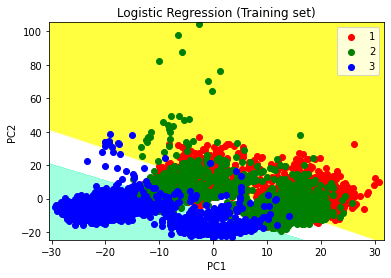

In [18]:
# Predicting the training set
# result through scatter plot 
from matplotlib.colors import ListedColormap
  
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
  
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('yellow', 'white', 'aquamarine')))
  
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
  
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
  
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend() # to show legend
  
# show scatter plot
plt.show()

(-29.90366142848625, 30.646338571523213)

(-22.047572715952246, 71.37242728406235)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Logistic Regression (Test set)')

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

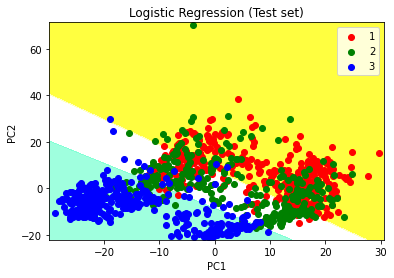

In [19]:
# Visualising the Test set results through scatter plot
from matplotlib.colors import ListedColormap

X_set, y_set = X_test, y_test

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
					stop = X_set[:, 0].max() + 1, step = 0.01),
					np.arange(start = X_set[:, 1].min() - 1,
					stop = X_set[:, 1].max() + 1, step = 0.01))

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
			X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
			cmap = ListedColormap(('yellow', 'white', 'aquamarine')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
	plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
				c = ListedColormap(('red', 'green', 'blue'))(i), label = j)

# title for scatter plot
plt.title('Logistic Regression (Test set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend()

# show scatter plot
plt.show()

In [27]:
#PCA on filtered data
x = df_filtered.iloc[:,:-1].values
y = df_filtered.iloc[:,-1].replace({'CBP' : 1, 'KAT5' : 2, 'eGFP' : 3}).values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

sc = StandardScaler()
  
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA(n_components = 2)
  
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
  
explained_variance = pca.explained_variance_ratio_

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

LogisticRegression(random_state=0)

In [28]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[282,  93,   1],
       [ 95, 161,  27],
       [  2,  17, 322]])

(-28.311785283874798, 30.108214716134334)

(-24.019150433790124, 40.89084956622002)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Logistic Regression (Training set)')

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

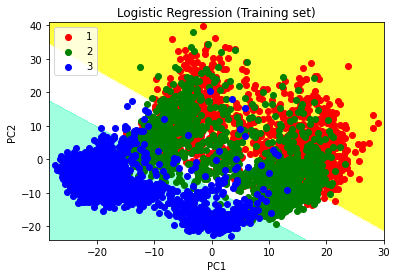

In [31]:
# Predicting the training set
# result through scatter plot 
from matplotlib.colors import ListedColormap
  
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
  
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('yellow', 'white', 'aquamarine')))
  
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
  
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
  
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend() # to show legend
  
# show scatter plot
plt.show()

(-27.763157162091858, 29.086842837917033)

(-21.75425031219714, 34.375749687811634)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Logistic Regression (Test set)')

Text(0.5, 0, 'PC1')

Text(0, 0.5, 'PC2')

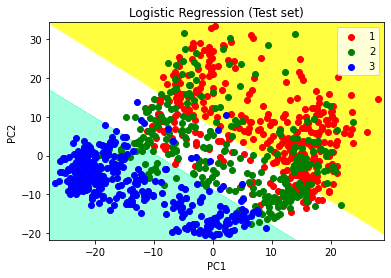

In [30]:
# Visualising the Test set results through scatter plot
from matplotlib.colors import ListedColormap

X_set, y_set = X_test, y_test

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
					stop = X_set[:, 0].max() + 1, step = 0.01),
					np.arange(start = X_set[:, 1].min() - 1,
					stop = X_set[:, 1].max() + 1, step = 0.01))

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
			X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
			cmap = ListedColormap(('yellow', 'white', 'aquamarine')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
	plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
				c = ListedColormap(('red', 'green', 'blue'))(i), label = j)

# title for scatter plot
plt.title('Logistic Regression (Test set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend()

# show scatter plot
plt.show()


In [ ]:
#results PCA not great...

## Method 1 XGBoost

- Once with our filtered data
- Also run with raw data to see if filtering has an effect

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# split into train and validation set using sklearn
gene_column_headers_filtered = gene_column_headers[:-1]
y = df_filtered['labels']
X = df_filtered.iloc[:,:-1]

# need to transform our labels from [KAT5, CBP, eGFP] -> [0,1,2] 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# perform a typical split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y)

training_data = {'X_train':X_train,'y_train':y_train,
                'X_test': X_val,'y_test':y_val}

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
# fit function where it takes the sklearn and xgboost models and performs the boosted trees.
# plots performance and accuracy as well

def fit(model, training_data=training_data, epochs=300, label_gene = gene_column_headers_filtered):
    # fitting to the sklearn model
    print('Fitting model...')
    model.fit(training_data['X_train'], training_data['y_train'])
    print('Fitting done!')

    # fitting the xboost library model
    train = xgb.DMatrix(training_data['X_train'], label=training_data['y_train'])
    test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
    params = model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    evaluation = {}
    evallist = [(test, 'test'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist, evals_result=evaluation,verbose_eval=100)

    # Model reports
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(model.predict(training_data['X_test']), training_data['y_test'])))
    print('XGBoost F1-Score: '+str(f1_score(model.predict(training_data['X_test']),training_data['y_test'], average='micro')))
    
    # plotting the error curves for our loss functions
    for m in metrics:
        test_score = evaluation['test'][m]
        train_score = evaluation['train'][m]
        x = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(x, test_score, label="Test")
        plt.plot(x, train_score, label="Train")
        
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Epoch')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
    
    # makes sure that the two array match so we can plot the feature importance
    print("length of features list: {}".format(len(gene_column_headers_filtered)))
    print("length of feature importance vector {}".format(len(model.feature_importances_)))

    return xgb_model

In [ ]:
training_data['X_test']

In [ ]:
# hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=9, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

read in test.csv.gz to assess model and predictions

In [ ]:
test = pd.read_csv('../data/test.csv.gz', compression='gzip', usecols=gene_column_headers_filtered)
test

In [ ]:
# get it into dmatrix again
X = test
testing_data = xgb.DMatrix(data=X)

In [ ]:
test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
pred = xgb_trained.predict(test)

In [ ]:
print(classification_report(training_data['y_test'], pred))

In [ ]:
confusion_matrix = confusion_matrix(training_data['y_test'], pred)

In [ ]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
# confusion matrix
plot_confusion_matrix(confusion_matrix, ['KAT5', 'CBP', 'eGFP'])

In [ ]:
import graphviz
plt.rcParams["figure.figsize"] = [22,40]
xgb.plot_tree(xgb_trained)

In [ ]:
plt.rcParams["figure.figsize"] = [22,22]
xgb.plot_importance(xgb_trained)

as expected alot of features aren't very important but lets still try running our classifier with our raw data 

In [ ]:
#hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=6, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

In [ ]:
test_data = pd.read_csv('../data/test.csv.gz', compression='gzip', usecols=gene_column_headers_filtered)
test = test_data

In [ ]:
# get it into dmatrix again
X = test
testing_data = xgb.DMatrix(test)

In [ ]:
test = xgb.DMatrix(training_data['X_test'], label=training_data['y_test'])
pred = xgb_trained.predict(test)

In [ ]:
print(classification_report(training_data['y_test'], pred))

In [ ]:
confusion_matrix = confusion_matrix(y_true=training_data['y_test'], y_pred=pred)

In [ ]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
# confusion matrix
plot_confusion_matrix(confusion_matrix, ['KAT5', 'CBP', 'eGFP'])

In [ ]:
#hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=12, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

In [ ]:
#hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=15, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

In [ ]:
#hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=10, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

Raw data. Assess performance

In [ ]:
# split into train and validation set using sklearn
y = df['labels']
X = df.loc[:, df.columns != 'labels'] 

# need to transform our labels from [KAT5, CBP, eGFP] -> [0,1,2] 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# perform a typical split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

data = {'X_train':X_train,'y_train':y_train,
                'X_test': X_val,'y_test':y_val}

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
# hyperparameters that can be adjusted in the final model
xgb_model = XGBClassifier(learning_rate=0.1, # play around with learning rate
                    n_estimators=300, # play around with number of boosted trees built
                    max_depth=5, # play around with tree depth
                    objective='multi:softmax',  # I saw that using softmax or softprob is best for multi class classification
                    nthread=4,
                    num_class=3,
                    seed=1 # seed is included for reproducibility
                    )

xgb_trained = fit(xgb_model, training_data)

train more different hyperparameter models

## Method 2: Sparse-Input Neural Networks

- Once with our filtered data
- Also run with raw data to see if filtering has an effect